In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'lens_flare', 'dirty_lens', 'gaussian_noise', 'random_occlusion', 'original', 'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution'}
Validation folders considered: {'lens_flare', 'dirty_lens', 'gaussian_noise', 'random_occlusion', 'original', 'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution'}
Test folders considered: {'lens_flare', 'dirty_lens', 'gaussian_noise', 'random_occlusion', 'original', 'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'lens_flare', 'dirty_lens', 'gaussian_noise', 'original', 'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution'}
Validation folders considered: {'lens_flare', 'dirty_lens', 'gaussian_noise', 'original', 'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution'}
Test folders considered: {'lens_flare', 'dirty_lens', 'gaussian_noise', 'original', 'motion_blur', 'blur', 'chromatic_aberration', 'low_resolution'}


In [7]:


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class Swish(nn.Module):
    """Swish activation function (x * sigmoid(x))"""
    def forward(self, x):
        return x * torch.sigmoid(x)

class SqueezeExcitation(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, in_planes, reduced_dim):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_planes, reduced_dim, 1),
            Swish(),
            nn.Conv2d(reduced_dim, in_planes, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

class StochasticDepth(nn.Module):
    """Stochastic Depth regularization"""
    def __init__(self, drop_rate):
        super().__init__()
        self.drop_rate = drop_rate

    def forward(self, x, residual):
        if not self.training:
            return residual + x
        
        if self.drop_rate > 0:
            batch_size = x.shape[0]
            random_tensor = (1 - self.drop_rate) + torch.rand(
                (batch_size, 1, 1, 1), dtype=x.dtype, device=x.device
            )
            binary_mask = torch.floor(random_tensor)
            x = x / (1 - self.drop_rate) * binary_mask
        return residual + x

class MBConvBlock(nn.Module):
    """Mobile Inverted Residual Bottleneck Block"""
    def __init__(self, in_planes, out_planes, kernel_size, stride, expand_ratio, se_ratio, drop_rate):
        super().__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.stride = stride
        self.expand_ratio = expand_ratio
        
        # Expansion phase
        hidden_dim = in_planes * expand_ratio
        self.expand_conv = nn.Conv2d(in_planes, hidden_dim, 1, bias=False) if expand_ratio != 1 else nn.Identity()
        self.expand_bn = nn.BatchNorm2d(hidden_dim) if expand_ratio != 1 else nn.Identity()
        
        # Depthwise convolution
        self.depthwise_conv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, 
                                       padding=(kernel_size-1)//2, groups=hidden_dim, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(hidden_dim)
        
        # Squeeze-and-Excitation
        se_planes = max(1, int(in_planes * se_ratio))
        self.se = SqueezeExcitation(hidden_dim, se_planes)
        
        # Output phase
        self.project_conv = nn.Conv2d(hidden_dim, out_planes, 1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_planes)
        
        # Stochastic depth
        self.stoch_depth = StochasticDepth(drop_rate)
        
        # Skip connection
        self.use_skip_connection = (stride == 1) and (in_planes == out_planes)
        
    def forward(self, x):
        residual = x
        
        # Expansion
        if self.expand_ratio != 1:
            x = Swish()(self.expand_bn(self.expand_conv(x)))
        
        # Depthwise
        x = Swish()(self.depthwise_bn(self.depthwise_conv(x)))
        
        # Squeeze-and-Excitation
        x = self.se(x)
        
        # Project
        x = self.project_bn(self.project_conv(x))
        
        # Skip connection and stochastic depth
        if self.use_skip_connection:
            x = self.stoch_depth(x, residual)
        
        return x

class MyEfficientNetB0(nn.Module):
    """EfficientNetB0 Implementation from Scratch"""
    def __init__(self, num_classes=4, width_coeff=1.0, depth_coeff=1.0, dropout_rate=0.2, drop_connect_rate=0.2):
        super().__init__()
        
        # EfficientNet-B0 baseline
        # [expansion, output_filter, num_repeat, stride, kernel_size, se_ratio]
        settings = [
            [1,  16, 1, 1, 3, 0.25],  # MBConv1_3x3, SE, 112 -> 112
            [6,  24, 2, 2, 3, 0.25],  # MBConv6_3x3, SE, 112 ->  56
            [6,  40, 2, 2, 5, 0.25],  # MBConv6_5x5, SE,  56 ->  28
            [6,  80, 3, 2, 3, 0.25],  # MBConv6_3x3, SE,  28 ->  14
            [6, 112, 3, 1, 5, 0.25],  # MBConv6_5x5, SE,  14 ->  14
            [6, 192, 4, 2, 5, 0.25],  # MBConv6_5x5, SE,  14 ->   7
            [6, 320, 1, 1, 3, 0.25],  # MBConv6_3x3, SE,   7 ->   7
        ]
        
        # Stem
        out_channels = _make_divisible(32 * width_coeff, 8)
        self.stem_conv = nn.Conv2d(3, out_channels, 3, stride=2, padding=1, bias=False)
        self.stem_bn = nn.BatchNorm2d(out_channels)
        
        # Building inverted residual blocks
        self.blocks = nn.ModuleList([])
        in_channels = out_channels
        
        total_blocks = sum([max(1, int(math.ceil(num_repeat * depth_coeff))) for _, _, num_repeat, _, _, _ in settings])
        block_idx = 0
        
        for expand_ratio, output_filter, num_repeat, stride, kernel_size, se_ratio in settings:
            output_filter = _make_divisible(output_filter * width_coeff, 8)
            num_repeat = max(1, int(math.ceil(num_repeat * depth_coeff)))
            
            for i in range(num_repeat):
                drop_rate = drop_connect_rate * block_idx / total_blocks
                
                self.blocks.append(MBConvBlock(
                    in_channels if i == 0 else output_filter,
                    output_filter,
                    kernel_size,
                    stride if i == 0 else 1,
                    expand_ratio,
                    se_ratio,
                    drop_rate
                ))
                
                block_idx += 1
            in_channels = output_filter
        
        # Head
        self.head_conv = nn.Conv2d(in_channels, _make_divisible(1280 * width_coeff, 8), 1, bias=False)
        self.head_bn = nn.BatchNorm2d(_make_divisible(1280 * width_coeff, 8))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(_make_divisible(1280 * width_coeff, 8), num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using appropriate methods"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Stem
        x = Swish()(self.stem_bn(self.stem_conv(x)))
        
        # Blocks
        for block in self.blocks:
            x = block(x)
        
        # Head
        x = Swish()(self.head_bn(self.head_conv(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x

In [8]:
import math
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyEfficientNetB0(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("EfficientNetB0 Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

EfficientNetB0 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 32, 112, 112]             288
       BatchNorm2d-4         [-1, 32, 112, 112]              64
 AdaptiveAvgPool2d-5             [-1, 32, 1, 1]               0
            Conv2d-6              [-1, 8, 1, 1]             264
             Swish-7              [-1, 8, 1, 1]               0
            Conv2d-8             [-1, 32, 1, 1]             288
           Sigmoid-9             [-1, 32, 1, 1]               0
SqueezeExcitation-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 16, 112, 112]             512
      BatchNorm2d-12         [-1, 16, 112, 112]              32
      MBConvBlock-13         [-1, 16, 112, 112]               0
         


🚀 Starting EfficientNetB0 Training for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:31<00:00,  1.73it/s, Loss=1.5185, Acc=0.3404]


✅ Training completed in 31.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.65it/s, Loss=1.5629, Acc=0.2746]


✅ Validation completed in 5.28s
🌟 New best EfficientNetB0 model found! Validation Accuracy: 0.2746

📊 Epoch 1 Summary:
│ Train Loss: 1.5185 | Train Acc: 0.3404
│ Val Loss:   1.5629 | Val Acc:   0.2746
│ Train Time: 31.14s | Val Time: 5.28s
│ Total Epoch Time: 36.43s
│ Best Val Acc: 0.2746 (Epoch 1)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.43it/s, Loss=1.1539, Acc=0.5387]


✅ Training completed in 22.20s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.09it/s, Loss=2.6029, Acc=0.3103]


✅ Validation completed in 3.42s
🌟 New best EfficientNetB0 model found! Validation Accuracy: 0.3103

📊 Epoch 2 Summary:
│ Train Loss: 1.1539 | Train Acc: 0.5387
│ Val Loss:   2.6029 | Val Acc:   0.3103
│ Train Time: 22.20s | Val Time: 3.42s
│ Total Epoch Time: 25.80s
│ Best Val Acc: 0.3103 (Epoch 2)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.42it/s, Loss=0.8797, Acc=0.6684]


✅ Training completed in 22.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.01it/s, Loss=2.1276, Acc=0.3616]


✅ Validation completed in 3.50s
🌟 New best EfficientNetB0 model found! Validation Accuracy: 0.3616

📊 Epoch 3 Summary:
│ Train Loss: 0.8797 | Train Acc: 0.6684
│ Val Loss:   2.1276 | Val Acc:   0.3616
│ Train Time: 22.33s | Val Time: 3.50s
│ Total Epoch Time: 25.83s
│ Best Val Acc: 0.3616 (Epoch 3)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.42it/s, Loss=0.5832, Acc=0.7987]


✅ Training completed in 22.35s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.12it/s, Loss=2.1441, Acc=0.3996]


✅ Validation completed in 3.41s
🌟 New best EfficientNetB0 model found! Validation Accuracy: 0.3996

📊 Epoch 4 Summary:
│ Train Loss: 0.5832 | Train Acc: 0.7987
│ Val Loss:   2.1441 | Val Acc:   0.3996
│ Train Time: 22.35s | Val Time: 3.41s
│ Total Epoch Time: 25.76s
│ Best Val Acc: 0.3996 (Epoch 4)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.38it/s, Loss=0.4028, Acc=0.8668]


✅ Training completed in 22.71s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.01it/s, Loss=2.0729, Acc=0.4129]


✅ Validation completed in 3.49s
🌟 New best EfficientNetB0 model found! Validation Accuracy: 0.4129

📊 Epoch 5 Summary:
│ Train Loss: 0.4028 | Train Acc: 0.8668
│ Val Loss:   2.0729 | Val Acc:   0.4129
│ Train Time: 22.71s | Val Time: 3.49s
│ Total Epoch Time: 26.21s
│ Best Val Acc: 0.4129 (Epoch 5)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.39it/s, Loss=0.3167, Acc=0.8903]


✅ Training completed in 22.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.07it/s, Loss=1.8036, Acc=0.4420]


✅ Validation completed in 3.44s
🌟 New best EfficientNetB0 model found! Validation Accuracy: 0.4420

📊 Epoch 6 Summary:
│ Train Loss: 0.3167 | Train Acc: 0.8903
│ Val Loss:   1.8036 | Val Acc:   0.4420
│ Train Time: 22.58s | Val Time: 3.44s
│ Total Epoch Time: 26.03s
│ Best Val Acc: 0.4420 (Epoch 6)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.37it/s, Loss=0.2321, Acc=0.9231]


✅ Training completed in 22.77s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.99it/s, Loss=1.9810, Acc=0.4420]


✅ Validation completed in 3.51s

📊 Epoch 7 Summary:
│ Train Loss: 0.2321 | Train Acc: 0.9231
│ Val Loss:   1.9810 | Val Acc:   0.4420
│ Train Time: 22.77s | Val Time: 3.51s
│ Total Epoch Time: 26.29s
│ Best Val Acc: 0.4420 (Epoch 6)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.37it/s, Loss=0.2562, Acc=0.9073]


✅ Training completed in 22.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.93it/s, Loss=2.4996, Acc=0.3973]


✅ Validation completed in 3.56s

📊 Epoch 8 Summary:
│ Train Loss: 0.2562 | Train Acc: 0.9073
│ Val Loss:   2.4996 | Val Acc:   0.3973
│ Train Time: 22.78s | Val Time: 3.56s
│ Total Epoch Time: 26.35s
│ Best Val Acc: 0.4420 (Epoch 6)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.35it/s, Loss=0.1879, Acc=0.9396]


✅ Training completed in 22.99s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.04it/s, Loss=2.3114, Acc=0.3705]


✅ Validation completed in 3.47s

📊 Epoch 9 Summary:
│ Train Loss: 0.1879 | Train Acc: 0.9396
│ Val Loss:   2.3114 | Val Acc:   0.3705
│ Train Time: 22.99s | Val Time: 3.47s
│ Total Epoch Time: 26.47s
│ Best Val Acc: 0.4420 (Epoch 6)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.33it/s, Loss=0.1070, Acc=0.9677]


✅ Training completed in 23.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.03it/s, Loss=2.1453, Acc=0.4129]


✅ Validation completed in 3.48s

📊 Epoch 10 Summary:
│ Train Loss: 0.1070 | Train Acc: 0.9677
│ Val Loss:   2.1453 | Val Acc:   0.4129
│ Train Time: 23.19s | Val Time: 3.48s
│ Total Epoch Time: 26.68s
│ Best Val Acc: 0.4420 (Epoch 6)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.34it/s, Loss=0.1084, Acc=0.9642]


✅ Training completed in 23.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.98it/s, Loss=1.9619, Acc=0.5112]


✅ Validation completed in 3.53s
🌟 New best EfficientNetB0 model found! Validation Accuracy: 0.5112

📊 Epoch 11 Summary:
│ Train Loss: 0.1084 | Train Acc: 0.9642
│ Val Loss:   1.9619 | Val Acc:   0.5112
│ Train Time: 23.10s | Val Time: 3.53s
│ Total Epoch Time: 26.63s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.32it/s, Loss=0.1169, Acc=0.9701]


✅ Training completed in 23.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.93it/s, Loss=2.2688, Acc=0.4732]


✅ Validation completed in 3.57s

📊 Epoch 12 Summary:
│ Train Loss: 0.1169 | Train Acc: 0.9701
│ Val Loss:   2.2688 | Val Acc:   0.4732
│ Train Time: 23.32s | Val Time: 3.57s
│ Total Epoch Time: 26.89s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:22<00:00,  2.35it/s, Loss=0.1593, Acc=0.9566]


✅ Training completed in 22.98s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.07it/s, Loss=2.1412, Acc=0.4911]


✅ Validation completed in 3.44s

📊 Epoch 13 Summary:
│ Train Loss: 0.1593 | Train Acc: 0.9566
│ Val Loss:   2.1412 | Val Acc:   0.4911
│ Train Time: 22.98s | Val Time: 3.44s
│ Total Epoch Time: 26.43s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.31it/s, Loss=0.0879, Acc=0.9736]


✅ Training completed in 23.43s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.73it/s, Loss=2.3200, Acc=0.4241]


✅ Validation completed in 3.76s

📊 Epoch 14 Summary:
│ Train Loss: 0.0879 | Train Acc: 0.9736
│ Val Loss:   2.3200 | Val Acc:   0.4241
│ Train Time: 23.43s | Val Time: 3.76s
│ Total Epoch Time: 27.19s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.29it/s, Loss=0.0860, Acc=0.9736]


✅ Training completed in 23.58s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.01it/s, Loss=2.1574, Acc=0.4107]


✅ Validation completed in 3.49s

📊 Epoch 15 Summary:
│ Train Loss: 0.0860 | Train Acc: 0.9736
│ Val Loss:   2.1574 | Val Acc:   0.4107
│ Train Time: 23.58s | Val Time: 3.49s
│ Total Epoch Time: 27.08s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.32it/s, Loss=0.0563, Acc=0.9836]


✅ Training completed in 23.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.00it/s, Loss=2.5304, Acc=0.3616]


✅ Validation completed in 3.50s

📊 Epoch 16 Summary:
│ Train Loss: 0.0563 | Train Acc: 0.9836
│ Val Loss:   2.5304 | Val Acc:   0.3616
│ Train Time: 23.29s | Val Time: 3.50s
│ Total Epoch Time: 26.80s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.31it/s, Loss=0.0362, Acc=0.9900]


✅ Training completed in 23.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  4.04it/s, Loss=2.1302, Acc=0.4754]


✅ Validation completed in 3.47s

📊 Epoch 17 Summary:
│ Train Loss: 0.0362 | Train Acc: 0.9900
│ Val Loss:   2.1302 | Val Acc:   0.4754
│ Train Time: 23.34s | Val Time: 3.47s
│ Total Epoch Time: 26.82s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.30it/s, Loss=0.0558, Acc=0.9836]


✅ Training completed in 23.47s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.80it/s, Loss=2.4708, Acc=0.4397]


✅ Validation completed in 3.69s

📊 Epoch 18 Summary:
│ Train Loss: 0.0558 | Train Acc: 0.9836
│ Val Loss:   2.4708 | Val Acc:   0.4397
│ Train Time: 23.47s | Val Time: 3.69s
│ Total Epoch Time: 27.16s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.25it/s, Loss=0.0509, Acc=0.9847]


✅ Training completed in 23.96s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.75it/s, Loss=2.1168, Acc=0.4353]


✅ Validation completed in 3.74s

📊 Epoch 19 Summary:
│ Train Loss: 0.0509 | Train Acc: 0.9847
│ Val Loss:   2.1168 | Val Acc:   0.4353
│ Train Time: 23.96s | Val Time: 3.74s
│ Total Epoch Time: 27.70s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.25it/s, Loss=0.0765, Acc=0.9795]


✅ Training completed in 23.97s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.82it/s, Loss=3.2538, Acc=0.3527]


✅ Validation completed in 3.68s

📊 Epoch 20 Summary:
│ Train Loss: 0.0765 | Train Acc: 0.9795
│ Val Loss:   3.2538 | Val Acc:   0.3527
│ Train Time: 23.97s | Val Time: 3.68s
│ Total Epoch Time: 27.65s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.29it/s, Loss=0.0332, Acc=0.9877]


✅ Training completed in 23.59s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.99it/s, Loss=2.4846, Acc=0.4375]


✅ Validation completed in 3.51s

📊 Epoch 21 Summary:
│ Train Loss: 0.0332 | Train Acc: 0.9877
│ Val Loss:   2.4846 | Val Acc:   0.4375
│ Train Time: 23.59s | Val Time: 3.51s
│ Total Epoch Time: 27.11s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.31it/s, Loss=0.0321, Acc=0.9888]


✅ Training completed in 23.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.98it/s, Loss=2.5365, Acc=0.4330]


✅ Validation completed in 3.52s

📊 Epoch 22 Summary:
│ Train Loss: 0.0321 | Train Acc: 0.9888
│ Val Loss:   2.5365 | Val Acc:   0.4330
│ Train Time: 23.37s | Val Time: 3.52s
│ Total Epoch Time: 26.90s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.29it/s, Loss=0.0412, Acc=0.9859]


✅ Training completed in 23.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.77it/s, Loss=2.6151, Acc=0.4174]


✅ Validation completed in 3.72s

📊 Epoch 23 Summary:
│ Train Loss: 0.0412 | Train Acc: 0.9859
│ Val Loss:   2.6151 | Val Acc:   0.4174
│ Train Time: 23.62s | Val Time: 3.72s
│ Total Epoch Time: 27.34s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.29it/s, Loss=0.0397, Acc=0.9906]


✅ Training completed in 23.57s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.84it/s, Loss=2.3887, Acc=0.4732]


✅ Validation completed in 3.66s

📊 Epoch 24 Summary:
│ Train Loss: 0.0397 | Train Acc: 0.9906
│ Val Loss:   2.3887 | Val Acc:   0.4732
│ Train Time: 23.57s | Val Time: 3.66s
│ Total Epoch Time: 27.23s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.32it/s, Loss=0.1771, Acc=0.9448]


✅ Training completed in 23.31s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.82it/s, Loss=2.3566, Acc=0.4509]


✅ Validation completed in 3.67s

📊 Epoch 25 Summary:
│ Train Loss: 0.1771 | Train Acc: 0.9448
│ Val Loss:   2.3566 | Val Acc:   0.4509
│ Train Time: 23.31s | Val Time: 3.67s
│ Total Epoch Time: 26.98s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.31it/s, Loss=0.0824, Acc=0.9707]


✅ Training completed in 23.38s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.91it/s, Loss=2.3421, Acc=0.4509]


✅ Validation completed in 3.59s

📊 Epoch 26 Summary:
│ Train Loss: 0.0824 | Train Acc: 0.9707
│ Val Loss:   2.3421 | Val Acc:   0.4509
│ Train Time: 23.38s | Val Time: 3.59s
│ Total Epoch Time: 26.97s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.33it/s, Loss=0.0752, Acc=0.9777]


✅ Training completed in 23.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.92it/s, Loss=2.4429, Acc=0.4397]


✅ Validation completed in 3.57s

📊 Epoch 27 Summary:
│ Train Loss: 0.0752 | Train Acc: 0.9777
│ Val Loss:   2.4429 | Val Acc:   0.4397
│ Train Time: 23.18s | Val Time: 3.57s
│ Total Epoch Time: 26.76s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.31it/s, Loss=0.0401, Acc=0.9888]


✅ Training completed in 23.33s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.93it/s, Loss=2.6531, Acc=0.4107]


✅ Validation completed in 3.57s

📊 Epoch 28 Summary:
│ Train Loss: 0.0401 | Train Acc: 0.9888
│ Val Loss:   2.6531 | Val Acc:   0.4107
│ Train Time: 23.33s | Val Time: 3.57s
│ Total Epoch Time: 26.91s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.30it/s, Loss=0.0902, Acc=0.9695]


✅ Training completed in 23.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.89it/s, Loss=2.8423, Acc=0.4375]


✅ Validation completed in 3.60s

📊 Epoch 29 Summary:
│ Train Loss: 0.0902 | Train Acc: 0.9695
│ Val Loss:   2.8423 | Val Acc:   0.4375
│ Train Time: 23.48s | Val Time: 3.60s
│ Total Epoch Time: 27.08s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.26it/s, Loss=0.0442, Acc=0.9853]


✅ Training completed in 23.85s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.91it/s, Loss=2.8196, Acc=0.3906]


✅ Validation completed in 3.58s

📊 Epoch 30 Summary:
│ Train Loss: 0.0442 | Train Acc: 0.9853
│ Val Loss:   2.8196 | Val Acc:   0.3906
│ Train Time: 23.85s | Val Time: 3.58s
│ Total Epoch Time: 27.44s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.19it/s, Loss=0.0254, Acc=0.9935]


✅ Training completed in 24.61s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.80it/s, Loss=2.9053, Acc=0.3884]


✅ Validation completed in 3.69s

📊 Epoch 31 Summary:
│ Train Loss: 0.0254 | Train Acc: 0.9935
│ Val Loss:   2.9053 | Val Acc:   0.3884
│ Train Time: 24.61s | Val Time: 3.69s
│ Total Epoch Time: 28.30s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.27it/s, Loss=0.1197, Acc=0.9619]


✅ Training completed in 23.84s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.87it/s, Loss=2.5336, Acc=0.4375]


✅ Validation completed in 3.62s

📊 Epoch 32 Summary:
│ Train Loss: 0.1197 | Train Acc: 0.9619
│ Val Loss:   2.5336 | Val Acc:   0.4375
│ Train Time: 23.84s | Val Time: 3.62s
│ Total Epoch Time: 27.46s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.28it/s, Loss=0.0436, Acc=0.9842]


✅ Training completed in 23.72s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.80it/s, Loss=2.1409, Acc=0.4442]


✅ Validation completed in 3.69s

📊 Epoch 33 Summary:
│ Train Loss: 0.0436 | Train Acc: 0.9842
│ Val Loss:   2.1409 | Val Acc:   0.4442
│ Train Time: 23.72s | Val Time: 3.69s
│ Total Epoch Time: 27.41s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.24it/s, Loss=0.0125, Acc=0.9971]


✅ Training completed in 24.06s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.54it/s, Loss=2.3137, Acc=0.4487]


✅ Validation completed in 3.96s

📊 Epoch 34 Summary:
│ Train Loss: 0.0125 | Train Acc: 0.9971
│ Val Loss:   2.3137 | Val Acc:   0.4487
│ Train Time: 24.06s | Val Time: 3.96s
│ Total Epoch Time: 28.02s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.24it/s, Loss=0.0223, Acc=0.9941]


✅ Training completed in 24.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.86it/s, Loss=2.2763, Acc=0.4420]


✅ Validation completed in 3.63s

📊 Epoch 35 Summary:
│ Train Loss: 0.0223 | Train Acc: 0.9941
│ Val Loss:   2.2763 | Val Acc:   0.4420
│ Train Time: 24.13s | Val Time: 3.63s
│ Total Epoch Time: 27.76s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.27it/s, Loss=0.0572, Acc=0.9771]


✅ Training completed in 23.80s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.84it/s, Loss=2.6273, Acc=0.3951]


✅ Validation completed in 3.65s

📊 Epoch 36 Summary:
│ Train Loss: 0.0572 | Train Acc: 0.9771
│ Val Loss:   2.6273 | Val Acc:   0.3951
│ Train Time: 23.80s | Val Time: 3.65s
│ Total Epoch Time: 27.45s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.26it/s, Loss=0.0321, Acc=0.9888]


✅ Training completed in 23.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.85it/s, Loss=2.3806, Acc=0.4152]


✅ Validation completed in 3.64s

📊 Epoch 37 Summary:
│ Train Loss: 0.0321 | Train Acc: 0.9888
│ Val Loss:   2.3806 | Val Acc:   0.4152
│ Train Time: 23.90s | Val Time: 3.64s
│ Total Epoch Time: 27.55s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.26it/s, Loss=0.0177, Acc=0.9947]


✅ Training completed in 23.89s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.73it/s, Loss=2.5825, Acc=0.4129]


✅ Validation completed in 3.76s

📊 Epoch 38 Summary:
│ Train Loss: 0.0177 | Train Acc: 0.9947
│ Val Loss:   2.5825 | Val Acc:   0.4129
│ Train Time: 23.89s | Val Time: 3.76s
│ Total Epoch Time: 27.66s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.28it/s, Loss=0.0640, Acc=0.9777]


✅ Training completed in 23.66s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.90it/s, Loss=2.2991, Acc=0.4085]


✅ Validation completed in 3.59s

📊 Epoch 39 Summary:
│ Train Loss: 0.0640 | Train Acc: 0.9777
│ Val Loss:   2.2991 | Val Acc:   0.4085
│ Train Time: 23.66s | Val Time: 3.59s
│ Total Epoch Time: 27.25s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.30it/s, Loss=0.0267, Acc=0.9918]


✅ Training completed in 23.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.74it/s, Loss=2.5716, Acc=0.4710]


✅ Validation completed in 3.75s

📊 Epoch 40 Summary:
│ Train Loss: 0.0267 | Train Acc: 0.9918
│ Val Loss:   2.5716 | Val Acc:   0.4710
│ Train Time: 23.48s | Val Time: 3.75s
│ Total Epoch Time: 27.23s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.26it/s, Loss=0.0091, Acc=0.9971]


✅ Training completed in 23.91s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.68it/s, Loss=2.6511, Acc=0.4531]


✅ Validation completed in 3.81s

📊 Epoch 41 Summary:
│ Train Loss: 0.0091 | Train Acc: 0.9971
│ Val Loss:   2.6511 | Val Acc:   0.4531
│ Train Time: 23.91s | Val Time: 3.81s
│ Total Epoch Time: 27.73s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.20it/s, Loss=0.0027, Acc=0.9994]


✅ Training completed in 24.57s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.63it/s, Loss=2.6815, Acc=0.4464]


✅ Validation completed in 3.86s

📊 Epoch 42 Summary:
│ Train Loss: 0.0027 | Train Acc: 0.9994
│ Val Loss:   2.6815 | Val Acc:   0.4464
│ Train Time: 24.57s | Val Time: 3.86s
│ Total Epoch Time: 28.44s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.26it/s, Loss=0.0066, Acc=0.9982]


✅ Training completed in 23.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.64it/s, Loss=2.8064, Acc=0.4509]


✅ Validation completed in 3.85s

📊 Epoch 43 Summary:
│ Train Loss: 0.0066 | Train Acc: 0.9982
│ Val Loss:   2.8064 | Val Acc:   0.4509
│ Train Time: 23.90s | Val Time: 3.85s
│ Total Epoch Time: 27.75s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.21it/s, Loss=0.0192, Acc=0.9947]


✅ Training completed in 24.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.65it/s, Loss=3.0302, Acc=0.4330]


✅ Validation completed in 3.85s

📊 Epoch 44 Summary:
│ Train Loss: 0.0192 | Train Acc: 0.9947
│ Val Loss:   3.0302 | Val Acc:   0.4330
│ Train Time: 24.46s | Val Time: 3.85s
│ Total Epoch Time: 28.31s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.23it/s, Loss=0.0092, Acc=0.9965]


✅ Training completed in 24.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.65it/s, Loss=2.8600, Acc=0.4286]


✅ Validation completed in 3.84s

📊 Epoch 45 Summary:
│ Train Loss: 0.0092 | Train Acc: 0.9965
│ Val Loss:   2.8600 | Val Acc:   0.4286
│ Train Time: 24.17s | Val Time: 3.84s
│ Total Epoch Time: 28.01s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.23it/s, Loss=0.0097, Acc=0.9959]


✅ Training completed in 24.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.57it/s, Loss=3.0329, Acc=0.4554]


✅ Validation completed in 3.92s

📊 Epoch 46 Summary:
│ Train Loss: 0.0097 | Train Acc: 0.9959
│ Val Loss:   3.0329 | Val Acc:   0.4554
│ Train Time: 24.21s | Val Time: 3.92s
│ Total Epoch Time: 28.14s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:24<00:00,  2.21it/s, Loss=0.0557, Acc=0.9824]


✅ Training completed in 24.41s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.63it/s, Loss=2.6682, Acc=0.4308]


✅ Validation completed in 3.86s

📊 Epoch 47 Summary:
│ Train Loss: 0.0557 | Train Acc: 0.9824
│ Val Loss:   2.6682 | Val Acc:   0.4308
│ Train Time: 24.41s | Val Time: 3.86s
│ Total Epoch Time: 28.28s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.28it/s, Loss=0.0679, Acc=0.9771]


✅ Training completed in 23.67s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.79it/s, Loss=3.2054, Acc=0.4286]


✅ Validation completed in 3.69s

📊 Epoch 48 Summary:
│ Train Loss: 0.0679 | Train Acc: 0.9771
│ Val Loss:   3.2054 | Val Acc:   0.4286
│ Train Time: 23.67s | Val Time: 3.69s
│ Total Epoch Time: 27.37s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.26it/s, Loss=0.0407, Acc=0.9871]


✅ Training completed in 23.86s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.66it/s, Loss=2.8816, Acc=0.4464]


✅ Validation completed in 3.83s

📊 Epoch 49 Summary:
│ Train Loss: 0.0407 | Train Acc: 0.9871
│ Val Loss:   2.8816 | Val Acc:   0.4464
│ Train Time: 23.86s | Val Time: 3.83s
│ Total Epoch Time: 27.69s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:23<00:00,  2.31it/s, Loss=0.0391, Acc=0.9883]


✅ Training completed in 23.40s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:03<00:00,  3.98it/s, Loss=3.3387, Acc=0.4018]


✅ Validation completed in 3.52s

📊 Epoch 50 Summary:
│ Train Loss: 0.0391 | Train Acc: 0.9883
│ Val Loss:   3.3387 | Val Acc:   0.4018
│ Train Time: 23.40s | Val Time: 3.52s
│ Total Epoch Time: 26.93s
│ Best Val Acc: 0.5112 (Epoch 11)
│ GPU Memory: 0.1GB / 4.1GB

💾 Best EfficientNetB0 model saved as 'best_efficientnetb0_model.pth'
📊 Best model stats:
│ Best Epoch: 11
│ Best Val Acc: 0.5112

💾 EfficientNetB0 training history saved to 'efficientnetb0_training_history.csv'

🎉 EfficientNetB0 Training Complete!
Total Training Time: 1367.69s (22.8 minutes)
Average Epoch Time: 27.35s

⏱️  Epoch Timing Breakdown:
│ Epoch 1: 36.43s
│ Epoch 2: 25.80s
│ Epoch 3: 25.83s
│ Epoch 4: 25.76s
│ Epoch 5: 26.21s
│ Epoch 6: 26.03s
│ Epoch 7: 26.29s
│ Epoch 8: 26.35s
│ Epoch 9: 26.47s
│ Epoch 10: 26.68s
│ Epoch 11: 26.63s
│ Epoch 12: 26.89s
│ Epoch 13: 26.43s
│ Epoch 14: 27.19s
│ Epoch 15: 27.08s
│ Epoch 16: 26.80s
│ Epoch 17: 26.82s
│ Epoch 18: 27.16s
│ Epoch 19: 27.70s
│ Epoch 20: 27.65s
│ Epoch 21: 27.1

Testing EfficientNetB0: 100%|██████████████████████████████| 18/18 [00:09<00:00,  1.97it/s]


✅ EfficientNetB0 Testing completed in 9.15s

📋 EfficientNetB0 Classification Report:
                 precision    recall  f1-score   support

  boundary_save       0.41      0.48      0.45       152
catching_a_ball       0.26      0.32      0.29       104
    diving_stop       0.11      0.11      0.11        56
        run_out       0.55      0.45      0.49       128
       stumping       0.44      0.37      0.40       120

       accuracy                           0.38       560
      macro avg       0.35      0.34      0.35       560
   weighted avg       0.39      0.38      0.38       560

🎯 EfficientNetB0 Test Accuracy: 0.3804

📊 EfficientNetB0 Model Performance Summary:
│ Best Validation Acc:  0.5112 (Epoch 11)
│ Final Test Accuracy:  0.3804
│ Val-Test Gap:         0.1308


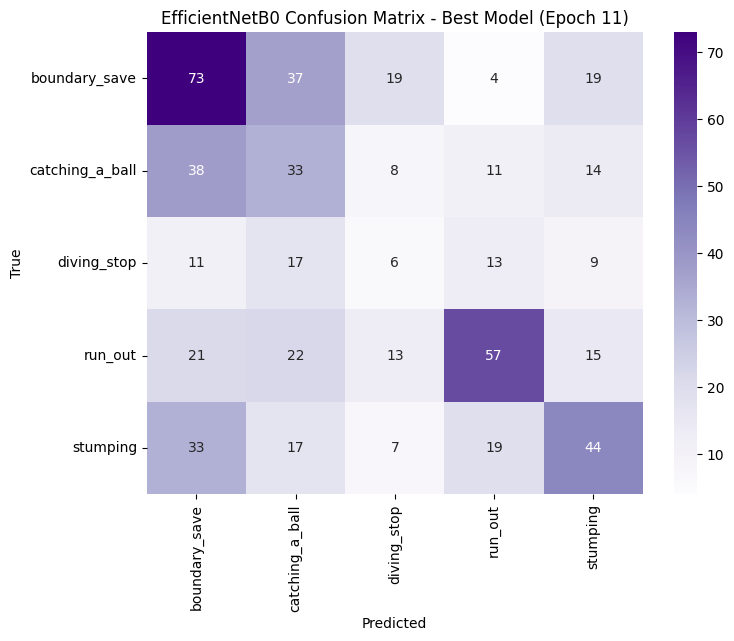

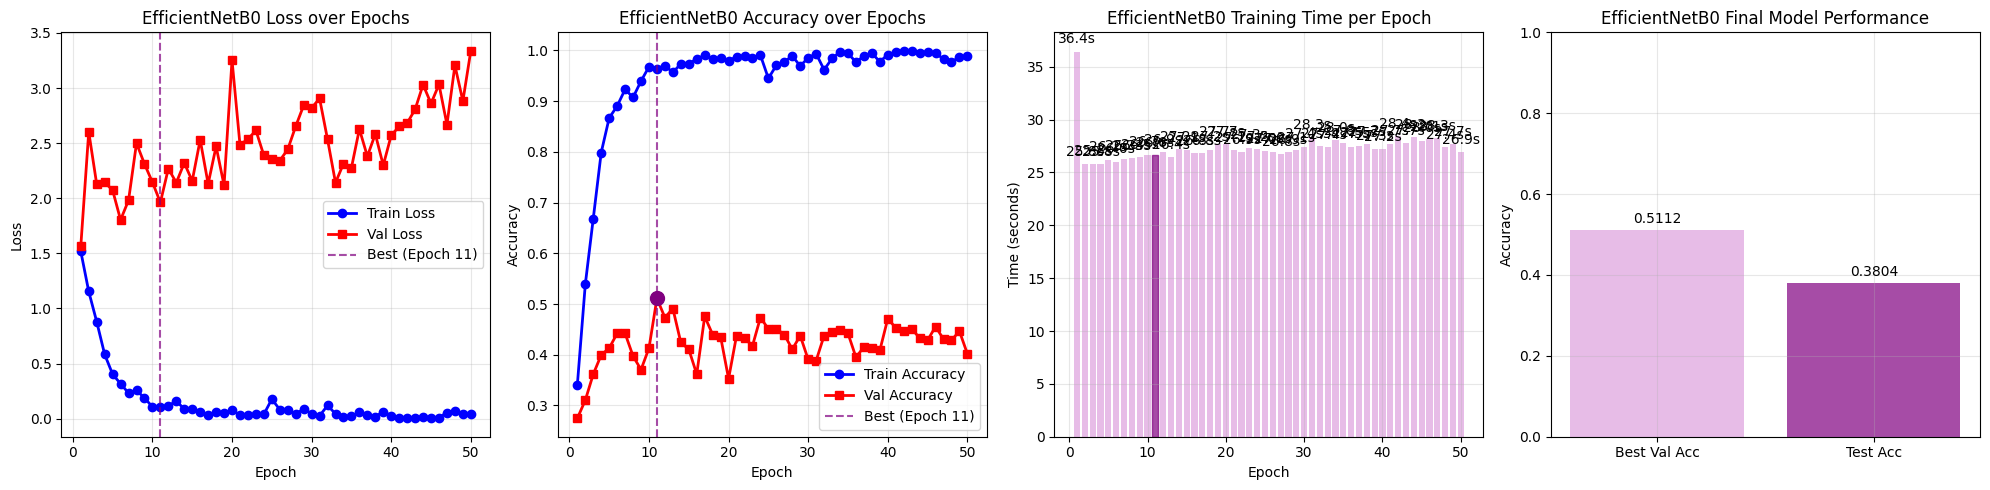


⏰ EfficientNetB0 Final Timing Summary:
│ Total Training: 1367.69s
│ Average per Epoch: 27.35s
│ Testing Time: 9.15s
│ Total Runtime: 1376.83s

💾 EfficientNetB0 Files saved:
│ best_efficientnetb0_model.pth - Best validation accuracy model
│ efficientnetb0_training_history.csv - Training metrics for later plotting

🏗️  EfficientNetB0 Architecture Summary:
│ Total Parameters: 4,013,953
│ Trainable Parameters: 4,013,953
│ Model Size: 15.31 MB
│ Input Size: 224x224x3
│ Output Classes: 5
│ Width Coefficient: 1.0
│ Depth Coefficient: 1.0
│ Dropout Rate: 0.2
│ Drop Connect Rate: 0.2
│ MBConv Blocks: 16
│ Squeeze-and-Excitation: Yes
│ Swish Activation: Yes
│ Stochastic Depth: Yes


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - EfficientNetB0
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\n🚀 Starting EfficientNetB0 Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best EfficientNetB0 model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_efficientnetb0_model.pth')
    print(f"\n💾 Best EfficientNetB0 model saved as 'best_efficientnetb0_model.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('efficientnetb0_training_history.csv', index=False)
print("\n💾 EfficientNetB0 training history saved to 'efficientnetb0_training_history.csv'")

# Training Summary
print(f"\n🎉 EfficientNetB0 Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n⏱️  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"│ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best EfficientNetB0 Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best EfficientNetB0 model from epoch {best_epoch} loaded successfully!")
else:
    print("⚠️  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing EfficientNetB0", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ EfficientNetB0 Testing completed in {test_time:.2f}s")
print("\n📋 EfficientNetB0 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 EfficientNetB0 Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\n📊 EfficientNetB0 Model Performance Summary:")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"EfficientNetB0 Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='purple', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("EfficientNetB0 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='purple', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='purple', s=100, zorder=5)
plt.legend()
plt.title("EfficientNetB0 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='plum', alpha=0.7)
bars[best_epoch-1].set_color('purple')
plt.title("EfficientNetB0 Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['plum', 'purple']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("EfficientNetB0 Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⏰ EfficientNetB0 Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\n💾 EfficientNetB0 Files saved:")
print(f"│ best_efficientnetb0_model.pth - Best validation accuracy model")
print(f"│ efficientnetb0_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. EfficientNetB0 Architecture Summary
# -----------------------------
print(f"\n🏗️  EfficientNetB0 Architecture Summary:")
print(f"│ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"│ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"│ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"│ Input Size: 224x224x3")
print(f"│ Output Classes: {len(classes)}")
print(f"│ Width Coefficient: 1.0")
print(f"│ Depth Coefficient: 1.0")
print(f"│ Dropout Rate: 0.2")
print(f"│ Drop Connect Rate: 0.2")
print(f"│ MBConv Blocks: {len(model.blocks)}")
print(f"│ Squeeze-and-Excitation: Yes")
print(f"│ Swish Activation: Yes")
print(f"│ Stochastic Depth: Yes")